> ## Since Blip2ForConditionalGeneration (“Salesforce/blip2-opt-2.7b”) uses more memory, I have loaded it in later part to avoid memory issues.
> ## Memory usage is provided for both the models before and after inference.  

In [1]:
try:
    import transformers
    print("Transformers is already installed.")
except ImportError:
    print("Transformers not found. Installing...")
    !pip install transformers

Transformers is already installed.


> models used
>> Blip2ForConditionalGeneration (“Salesforce/blip2-opt-2.7b”): is used for conditional generation like, asking for cpationing image, and visual Q&A.

>> Blip2ForImageTextRetrieval("Salesforce/blip2-itm-vit-g"): is used for ZS text retrival for a given image.

In [2]:
import torch
from transformers import (Blip2ForImageTextRetrieval,Blip2ForConditionalGeneration,AutoProcessor, AddedToken)

In [3]:
def memory_stats():
    # print("GPU memory Allocated: ",torch.cuda.me()/1024**2)
    freeMem, total  = torch.cuda.mem_get_info()
    print(f"GPU memory Total: [{total/1024**2:.2f}] Available: [{freeMem/1024**2:.2f}] Allocated: [{torch.cuda.memory_allocated()/1024**2:.2f}] Reserved: [{torch.cuda.memory_reserved()/1024**2:.2f}]")

In [4]:
memory_stats()

GPU memory Total: [15095.06] Available: [14992.12] Allocated: [0.00] Reserved: [0.00]


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
tr_model = Blip2ForImageTextRetrieval.from_pretrained("Salesforce/blip2-itm-vit-g", torch_dtype=torch.float16).to(device)
processor = AutoProcessor.from_pretrained("Salesforce/blip2-itm-vit-g")

# this is updated to avoid warning for deprecation for blip2 processor. ref: https://gist.github.com/zucchini-nlp/e9f20b054fa322f84ac9311d9ab67042
processor.num_query_tokens = tr_model.config.num_query_tokens
image_token = AddedToken("<image>", normalized=False, special=True)
processor.tokenizer.add_tokens([image_token], special_tokens=True)
tr_model.resize_token_embeddings(len(processor.tokenizer), pad_to_multiple_of=64) # pad for efficient computation
tr_model.config.image_token_index = len(processor.tokenizer) - 1

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


>  Blip2 conditional generation model have size around 15gb which is capabity of T4 GPU on colab so,we first load Blip2ForImageTextRetrieval only and measured memory usage.
> on this run it uses around 2446Mib before inference.

In [6]:
memory_stats()

GPU memory Total: [15095.06] Available: [12374.12] Allocated: [2279.11] Reserved: [2592.00]


> Download image to test

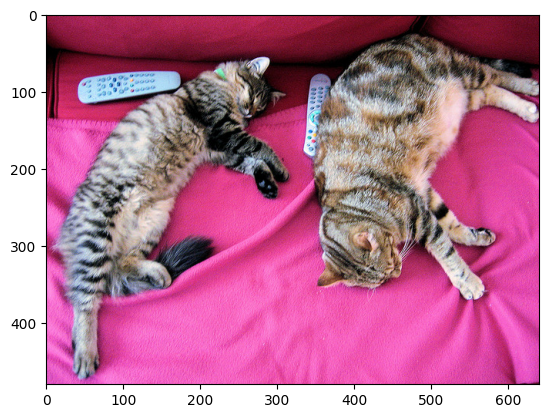

In [7]:
from PIL import Image
import requests
import matplotlib.pyplot as plt

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

plt.imshow(image)

In [8]:
possible_texts = ["a photo of a cat",
         "a photo of a dog",
         "a photo of two cats",
         "a photo of two cats sleeping on a pink blanket",
         "a photo of two remote control on a pink blanket",
         "a photo of two pink sofa",
         "a photo of pink bed",
         "a photo of two dogs sleeping on pink blanket",
         "a photo of cats playing with remote control",
         "a photo of remote controlled cat toys"]

In [9]:
inputs = processor(images=image, text=possible_texts, return_tensors="pt", padding=True).to(device, torch.float16) # added padding to true, to match all text length, else it will throw an error.
itc_out = tr_model(**inputs, use_image_text_matching_head=False)
logits_per_image = itc_out.logits_per_image  # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities

In [10]:
max_prob_index = probs[0].argmax()
for idx,text in enumerate(possible_texts):
  print_statement = f"[{probs[0][idx]:.1%}] that image is of '{text}'"
  if max_prob_index == idx:
    print_statement  = f"\n{print_statement} <=== [BEST MATCH]\n"
  print(print_statement)

[9.4%] that image is of 'a photo of a cat'
[8.5%] that image is of 'a photo of a dog'
[9.9%] that image is of 'a photo of two cats'

[11.4%] that image is of 'a photo of two cats sleeping on a pink blanket' <=== [BEST MATCH]

[10.5%] that image is of 'a photo of two remote control on a pink blanket'
[10.1%] that image is of 'a photo of two pink sofa'
[9.6%] that image is of 'a photo of pink bed'
[10.6%] that image is of 'a photo of two dogs sleeping on pink blanket'
[10.2%] that image is of 'a photo of cats playing with remote control'
[9.9%] that image is of 'a photo of remote controlled cat toys'


> after inference, the memory usage is around 3138Mib






In [11]:
memory_stats()

GPU memory Total: [15095.06] Available: [11864.12] Allocated: [2958.34] Reserved: [3098.00]


> Clean GPU memory to use other model in current session

In [12]:
del tr_model
del processor
del inputs
del itc_out
del logits_per_image
del probs
torch.cuda.empty_cache()

In [13]:
import gc
gc.collect()

272

> Now Load Conditional Generation Model.
> Let's check memory usage before loading the model

In [14]:
memory_stats()

GPU memory Total: [15095.06] Available: [12548.12] Allocated: [184.39] Reserved: [2414.00]


In [15]:
from transformers import Blip2Processor, Blip2ForConditionalGeneration

processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
cgen_model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", device_map="auto", torch_dtype=torch.float16)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

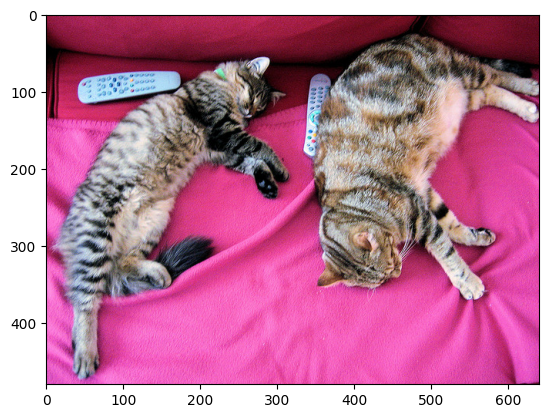

In [16]:
img_url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')
plt.imshow(raw_image)

> check memory usage for Blip conditional generation model

In [17]:
memory_stats()

GPU memory Total: [15095.06] Available: [7526.12] Allocated: [7187.70] Reserved: [7436.00]


> Inference common function to test on various prompts

In [18]:
@torch.no_grad()
def InferBlip(cgen_model, processor, image, question, min_length=16, max_length=64,temperature=0.0,repetition_penalty=1.3):
  inputs = processor(images=image, text=question, return_tensors="pt").to(device="cuda", dtype=torch.float16)
  do_sample = False
  if temperature > 0:
    do_sample = True

  if not do_sample:
    generated_ids = cgen_model.generate(**inputs, min_length=min_length,repetition_penalty=repetition_penalty,do_sample=do_sample,max_new_tokens=max_length)
  else:
    generated_ids = cgen_model.generate(**inputs, min_length=min_length,repetition_penalty=repetition_penalty,do_sample=do_sample, temperature=temperature,max_new_tokens=max_length)

  generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
  return generated_text


> lets get captions

In [19]:
prompt = "Q: Provide a long caption for the provided image.\nAns:"
generated_text = InferBlip(cgen_model, processor, raw_image, prompt, min_length=5,max_length=64, temperature=0.0)
print(generated_text)

Q: Provide a long caption for the provided image.
Ans: The cats are sleeping on top of each other, and one is laying down with its head resting in another cat's lap while it watches TV or plays video games; they're both wearing pink blankets to protect them from being scratched by their human companions' hands as well as any furniture that might be nearby (the couch).


In [20]:
prompt = "Q: Provide a short caption for the provided image.\nAns:"
generated_text = InferBlip(cgen_model, processor, raw_image, prompt, min_length=5,max_length=30, temperature=0.0) # change max length to rtetrict model to generate short caption.
print(generated_text)

Q: Provide a short caption for the provided image.
Ans: Two cats on pink couch, one cat sleeping and another watching TV with remote control in hand


> Memory usage after inference

In [21]:
memory_stats()

GPU memory Total: [15095.06] Available: [7414.12] Allocated: [7187.70] Reserved: [7546.00]


>> Fail cases

In [22]:
prompt = "Q: generate caption for the provided image Answer:"  # here if we dont provide "." at the end of question it fails to answer
generated_text = InferBlip(cgen_model, processor, raw_image, prompt)
print(generated_text)

Q: generate caption for the provided image Answer:


In [23]:
prompt = "Q: Can you please generate caption for the provided image? Answer:"  # bias towrds yes/no questionb
generated_text = InferBlip(cgen_model, processor, raw_image, prompt)
print(generated_text)

Q: Can you please generate caption for the provided image? Answer: Yes, I can


In [24]:
prompt = "Q: please generate detailed long description for the provided image. Answer:"  # very short answer despite asking for detailed description.
generated_text = InferBlip(cgen_model, processor, raw_image, prompt, max_length=120)
print(generated_text)

Q: please generate detailed long description for the provided image. Answer: cats on a couch


In [25]:
prompt = "Q: what is the color of the remotes in the image? Answer:"   # color is not correct
generated_text = InferBlip(cgen_model, processor, raw_image, prompt)
print(generated_text)

Q: what is the color of the remotes in the image? Answer: pink


In [26]:
prompt = "Q: How many legs the cat on the left have? Answer:" # wrong count for the object attributes
generated_text = InferBlip(cgen_model, processor, raw_image, prompt)
print(generated_text)

Q: How many legs the cat on the left have? Answer: Two


> working success prompts

In [27]:
prompt = "Q: generate caption for the provided image. Answer:"  # here if we provide "." at the end of question the it answers.
generated_text = InferBlip(cgen_model, processor, raw_image, prompt)
print(generated_text)

Q: generate caption for the provided image. Answer: two cats on a couch


In [28]:
prompt = "Q: how many cats are there in the image? Answer:"
generated_text = InferBlip(cgen_model, processor, raw_image, prompt)
print(generated_text)

Q: how many cats are there in the image? Answer: two


In [29]:
prompt = "Q: how many remotes are there in the image? Answer:"
generated_text = InferBlip(cgen_model, processor, raw_image, prompt)
print(generated_text)

Q: how many remotes are there in the image? Answer: two


In [30]:
prompt = "Q: how many remotes are there in the image? Answer:"
generated_text = InferBlip(cgen_model, processor, raw_image, prompt)
print(generated_text)

Q: how many remotes are there in the image? Answer: two


> finish the sentence

In [31]:
prompt = "two cats sleeping on a couch with remotes and television remote control in foreground, background is "
generated_text = InferBlip(cgen_model, processor, raw_image, prompt,  min_length=64)
print(generated_text)

two cats sleeping on a couch with remotes and television remote control in foreground, background is  pink blanket covered sofa

	cat laying down next to cat


> Inference on Custom Image

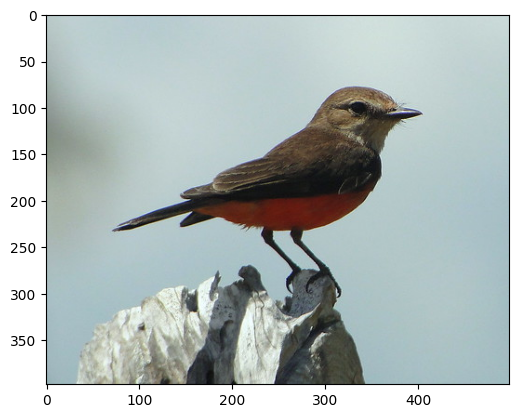

In [32]:
img_url = 'http://farm4.static.flickr.com/3488/4051378654_238ca94313.jpg'
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')

plt.imshow(raw_image)

In [33]:
prompt = "Q: Provide a short caption for the provided image.\nAns:"
generated_text = InferBlip(cgen_model, processor, raw_image, prompt, min_length=5,max_length=30) # change max length to rtetrict model to generate short caption.
print(generated_text)

Q: Provide a short caption for the provided image.
Ans: Red-tailed hawk, rufous-bellied warbler , blackpoll warblers and other birds of prey are common in this area


In [34]:
prompt = "Q: How many birds are there in the provided image.\nAns:"
generated_text = InferBlip(cgen_model, processor, raw_image, prompt, min_length=5,max_length=30) # change max length to rtetrict model to generate short caption.
print(generated_text)

Q: How many birds are there in the provided image.
Ans: There is a total of 5 species shown here, including 2 Red-tailed Hawk and 1 Black Vulture . The other 3 bird images can be found


In [35]:
prompt = "Q: is the bird fying in the provided image.\nAns:"
generated_text = InferBlip(cgen_model, processor, raw_image, prompt, min_length=5,max_length=30) # change max length to rtetrict model to generate short caption.
print(generated_text)

Q: is the bird fying in the provided image.
Ans: yes, it's a red-tailed hawk owl sitting on top of an old tree stump with its head down and looking at something behind him or her


In [36]:
prompt = "Q: is the bird standing on a rock in the provided image.\nAns:"
generated_text = InferBlip(cgen_model, processor, raw_image, prompt, min_length=5,max_length=30) # change max length to rtetrict model to generate short caption.
print(generated_text)

Q: is the bird standing on a rock in the provided image.
Ans: yes, it's an adult male red-tailed hawk owl perched atop of some rocks at lake michigan state park near fenton mi june


In [37]:
prompt = "Q: what do you see in the provided image.\nAns:"
generated_text = InferBlip(cgen_model, processor, raw_image, prompt, min_length=5,max_length=30) # change max length to rtetrict model to generate short caption.
print(generated_text)

Q: what do you see in the provided image.
Ans: a red-tailed blackbird, rufous-bellied woodpecker or eastern phoebe on top of an old stump with some branches


In [38]:
prompt = "Q: what color is the bird?\nAns:"
generated_text = InferBlip(cgen_model, processor, raw_image, prompt, min_length=5,max_length=30) # change max length to rtetrict model to generate short caption.
print(generated_text)

Q: what color is the bird?
Ans: red-winged blackbird, rufous-crowned warbler or northern cardinal


In [39]:
prompt = "Q: can you see a nest around the bird?\nAns:"
generated_text = InferBlip(cgen_model, processor, raw_image, prompt, min_length=5,max_length=30) # change max length to rtetrict model to generate short caption.
print(generated_text)

Q: can you see a nest around the bird?
Ans: yes, there is one in this picture. The red and black birds are nesting together at present time . They have been doing so for some years now


In [40]:
prompt = "Q: what food the bird is eating?\nAns:"
generated_text = InferBlip(cgen_model, processor, raw_image, prompt, min_length=5,max_length=30) # change max length to rtetrict model to generate short caption.
print(generated_text)

Q: what food the bird is eating?
Ans: it's a small insect, probably an ant. The red and black coloration of its body indicates that this species has been feeding on ants for some


In [41]:
prompt = "Q: how many baby birds are there in the image?\nAns:"
generated_text = InferBlip(cgen_model, processor, raw_image, prompt, min_length=5,max_length=30) # change max length to rtetrict model to generate short caption.
print(generated_text)

Q: how many baby birds are there in the image?
Ans: 1, 2 or 3. The bird is on a branch and has its wings spread out to show off it's feathers


In [42]:
prompt = "Q: Do you see bird eggs in the image ?\nAns:"
generated_text = InferBlip(cgen_model, processor, raw_image, prompt, min_length=5,max_length=30) # change max length to rtetrict model to generate short caption.
print(generated_text)

Q: Do you see bird eggs in the image ?
Ans: Yes, there are some egg shells on a tree stump. The birds have laid their eggs and fledged them from this spot to another location where they


## potential limitations

1. "." or "?" at the end of question is neccesary else instructions are not being followed, so better tokenizer is needed to understand the insturctions.
2. Model fails to understand object attributes (like number of legs, or color of object).
3. Long captions results in hallucination due to low confidence next token prediction.


## model capabilities

1. Excellent for zero shot image captioning
2. Good for short Q&A, answers yes no or count based question, should be really good for tasks dealing with yes/no(validation) or count for specific objects.


## possible tweaks

1. short caption can be improved for asking to continue or fill the blanks kind of questions by passing generated text back to the model.